#Overview

The purpose of this notebook is to conduct a basic twitter mining exercise and to demonstrate how to apply exploration techniques and machine learning algorithms for NLP . To do so, the notebook will first resort to the use of the twitter API to mine selected tweets, based on certain queries, before moving to explore the collected data and apply machine learning algorithms.

The questions of interest for this project are:

* How to mine x tweets for N active politicians?
* Determine which politicians are similar to each other.
* Train a N-ary classifier that assigns a tweet to a politician

#Data Collection


The data collection will be done using the Twitter API, using the Twython Package, based on certain queries. It should be noted that the population of interest for this study are US based politicians who are active on twitter. The definition of an active politician for the purposes of this study will be an elected member of congress whose verified twitter account exists and has not been suspended.

In [1]:
#Install the packages
!pip install twython
!pip install spacy
!pip install nltk
!pip install string
!pip install tqdm
!pip install -U -q PyDrive
!pip install nltk
!pip install mpld3  

  Stored in directory: /root/.cache/pip/wheels/c2/b0/a3/5c4b4b87b8c9e4d99f1494a0b471f0134a74e5fb33d426d009
Successfully built twython
    100% |████████████████████████████████| 17.3MB 1.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Successfully built wrapt
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.1 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: wrapt 1.11.1
    Uninstalling wrapt-1.11.1:
      Successfully uninstalled wrapt-1.11.1


  Could not find a version that satisfies the requirement string (from versions: )
No matching distribution found for string
    100% |████████████████████████████████| 993kB 18.1MB/s 
    100% |████████████████████████████████| 798kB 21.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


In [2]:
#Import libraries
import json
from twython import Twython  
import pandas as pd
from pandas import DataFrame
from IPython.display import display
import requests
from bs4 import BeautifulSoup
import numpy as np
from twython import TwythonStreamer
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import string
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Enter keys/secrets as strings
credentials = {}  
credentials['CONSUMER_KEY'] = 'atSt451PXQMb2SaphlCpf3VfR'   
credentials['CONSUMER_SECRET'] = '8PTV9LwkiC1UfjgEReoGswcyyGveaBGLaF3H1sEAl6gjRP6Ihg'   
credentials['ACCESS_TOKEN'] = '1093576775806922757-7O9nh5y5HtRgSRCcZPE1CRndApczEg'  
credentials['ACCESS_SECRET'] = '6iX8cAC8ywopZECDN7IdxVCQijn0TH3OB9xEVc6RFprTc' 

# Save the credentials object to json dump
with open("twitter_credentials.json", "w") as file:  
    json.dump(credentials, file)


# Load Twitter API credentials from predefined json file with API access keys 
with open("twitter_credentials.json", "r") as file:  
    creds = json.load(file)

To obtain the population of interest, the [official twitter list of verified US congress members](https://twitter.com/verified/lists/us-congress/members?lang=en) will be used to select  the politicians with the most followers. The aforementioned list will be scraped and filtered to that effect.

In [0]:
#Adapted from: https://www.dataquest.io/blog/web-scraping-tutorial-python/

#Send GET HTML request  to get webpage content
page = requests.get("https://twitter.com/verified/lists/us-congress/members?lang=en")

#Parse/structure the webpage content using Beautifulsoup
soup = BeautifulSoup(page.content, 'html.parser')

#check items in parsed webpage
#[type(item) for item in list(soup.children)]

In [5]:
#print out the descendants of the parsed page
html = list(soup.descendants)[2]
#print(html)

#Since all twitter names are found in the 'a' tag, filter by the latter and extract

#find all ocurrances of the tag and extract the text
selection = soup.find_all('a',attrs = {"class":"account-group js-user-profile-link"})

#create a list and append every twitter name
selected =[]
for link in selection:
    selected.append(link.get('href'))
    
#clean the strings by removing the '/' character
filtered = [s.replace('/', '') for s in selected]
comma_separated_string = ",".join(filtered)
print(comma_separated_string)

JoeLieberman,BachusAL06,RepRonPaul,Robert_Aderholt,JudgeTedPoe,SenBobCorker,VoteMarsha,RepAdamSmith,RepMikeQuigley,BillCassidy,BilbrayCA50,DrPhilRoe,RepMcClintock,Jim_Moran,RepJimMatheson,GabbyGiffords,SenSherrodBrown,DeanHeller,eltongallegly24,RepJoeBaca


After obtaining a list of associated screen names, the latter will be used to show statisitics of interest about each user using the twitter API.

In [0]:
# Instantiate an object using the Twython API
defined_tweets = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])

In [0]:
# result = defined_tweets.show_user(screen_name = 'JoeLieberman')
# print(result)

# create a list based on twitter stats for each user
## Since the Twitter API does not appear to allow multiple users to be queried at once
## the process will be done individually (and not iteratively) and appended to a list

#Define empty list
userbase = []

#Append every search result
userbase.append(defined_tweets.show_user(screen_name = 'JoeLieberman'))
userbase.append(defined_tweets.show_user(screen_name = 'BachusAL06'))
userbase.append(defined_tweets.show_user(screen_name = 'RepRonPaul'))
userbase.append(defined_tweets.show_user(screen_name = 'Robert_Aderholt'))
userbase.append(defined_tweets.show_user(screen_name = 'JudgeTedPoe'))
userbase.append(defined_tweets.show_user(screen_name = 'SenBobCorker'))
userbase.append(defined_tweets.show_user(screen_name = 'VoteMarsha'))
userbase.append(defined_tweets.show_user(screen_name = 'RepAdamSmith'))
userbase.append(defined_tweets.show_user(screen_name = 'RepMikeQuigley'))
userbase.append(defined_tweets.show_user(screen_name = 'BillCassidy'))
userbase.append(defined_tweets.show_user(screen_name = 'BilbrayCA50'))
userbase.append(defined_tweets.show_user(screen_name = 'DrPhilRoe'))
userbase.append(defined_tweets.show_user(screen_name = 'RepMcClintock'))
userbase.append(defined_tweets.show_user(screen_name = 'Jim_Moran'))
userbase.append(defined_tweets.show_user(screen_name = 'RepJimMatheson'))
userbase.append(defined_tweets.show_user(screen_name = 'GabbyGiffords'))
userbase.append(defined_tweets.show_user(screen_name = 'SenSherrodBrown'))
userbase.append(defined_tweets.show_user(screen_name = 'DeanHeller'))
userbase.append(defined_tweets.show_user(screen_name = 'eltongallegly24'))
userbase.append(defined_tweets.show_user(screen_name = 'RepJoeBaca'))

#convert list of lists to dataframe
user_base  = DataFrame.from_records(userbase)
#list(user_base)

In [8]:
#Filter dataframe as per required fields
filtered = user_base[['name',  
            'screen_name',
            'location',
            'followers_count',
            'created_at',
            'statuses_count',
            'lang',
            'verified',
            ]]

#Display first 10 results of data frame
filtered.head(5)

,name,screen_name,location,followers_count,created_at,statuses_count,lang,verified
0,Joe Lieberman,JoeLieberman,,31723,Wed Oct 21 18:28:29 +0000 2009,745,en,True
1,Spencer Bachus,BachusAL06,Washington,8152,Tue Sep 29 22:15:34 +0000 2009,532,en,True
2,Ron Paul,RepRonPaul,"Lake Jackson, TX",158938,Thu Sep 24 15:31:34 +0000 2009,508,en,True
3,Rep. Robert Aderholt,Robert_Aderholt,"Haleyville, AL",24520,Tue Sep 22 21:16:37 +0000 2009,1618,en,True
4,Ted Poe,JudgeTedPoe,"Humble, Texas",34587,Mon Sep 14 16:40:24 +0000 2009,5442,en,True


With the exception of *Elton Gallegly* in the above list, the remaining selected users are verified and fit the definition of an active politician. 

200 tweets (the maximum allowed per user) will consequently be mined for each user and stored. 	

In [0]:
#Since request for tweets was unauthorized with the implementation of a for loop,
#the mining will be done indivually and appended to the first database

#Obtain the first list of tweets from the first user 
Datcreate = defined_tweets.get_user_timeline(screen_name='JoeLieberman',include_rts=True,count = 200)
#Convert list to dataframe
Datcreated = DataFrame.from_records(Datcreate)

#2nd user 
Datcreate1 = defined_tweets.get_user_timeline(screen_name='BachusAL06', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated1 = DataFrame.from_records(Datcreate1)

#3rd user 
Datcreate2 = defined_tweets.get_user_timeline(screen_name='RepRonPaul', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated2 = DataFrame.from_records(Datcreate2)

#4th user
Datcreate3 = defined_tweets.get_user_timeline(screen_name='Robert_Aderholt', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated3 = DataFrame.from_records(Datcreate3)

#5th user
Datcreate4 = defined_tweets.get_user_timeline(screen_name='JudgeTedPoe', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated4 = DataFrame.from_records(Datcreate4)

#6th user
Datcreate5 = defined_tweets.get_user_timeline(screen_name='SenBobCorker', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated5 = DataFrame.from_records(Datcreate5)
        
#7th user
Datcreate6 = defined_tweets.get_user_timeline(screen_name='VoteMarsha', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated6 = DataFrame.from_records(Datcreate6)

#8th user
Datcreate7 = defined_tweets.get_user_timeline(screen_name='RepAdamSmith', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated7 = DataFrame.from_records(Datcreate7)

#9th user
Datcreate8 = defined_tweets.get_user_timeline(screen_name='RepMikeQuigley', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated8 = DataFrame.from_records(Datcreate8)

#10th user
Datcreate9 = defined_tweets.get_user_timeline(screen_name='BillCassidy', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated9 = DataFrame.from_records(Datcreate9)

#11th user
Datcreate10 = defined_tweets.get_user_timeline(screen_name='BilbrayCA50', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated10 = DataFrame.from_records(Datcreate10)
                   
#12th user
Datcreate11 = defined_tweets.get_user_timeline(screen_name='DrPhilRoe', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated11 = DataFrame.from_records(Datcreate11)

#13th user
Datcreate12= defined_tweets.get_user_timeline(screen_name='RepMcClintock', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated12 = DataFrame.from_records(Datcreate12)

#14th user
Datcreate13= defined_tweets.get_user_timeline(screen_name='Jim_Moran', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated13 = DataFrame.from_records(Datcreate13)

#15th user
Datcreate14= defined_tweets.get_user_timeline(screen_name='RepJimMatheson', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated14 = DataFrame.from_records(Datcreate14)

#16th user
Datcreate15= defined_tweets.get_user_timeline(screen_name='GabbyGiffords', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated15 = DataFrame.from_records(Datcreate15)

#17th user
Datcreate16= defined_tweets.get_user_timeline(screen_name='SenSherrodBrown', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated16 = DataFrame.from_records(Datcreate16)

#18th user
Datcreate17= defined_tweets.get_user_timeline(screen_name='DeanHeller', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated17 = DataFrame.from_records(Datcreate17)

#19th user
Datcreate18= defined_tweets.get_user_timeline(screen_name='RepJoeBaca', include_rts=True,count = 200)
#Convert list to dataframe
Datcreated18 = DataFrame.from_records(Datcreate18)                     

In [0]:
#Concatenate all dataframes and reset index
mining = pd.concat([Datcreated,Datcreated1,Datcreated2,Datcreated3,Datcreated4,Datcreated5,
                    Datcreated6,Datcreated7,Datcreated8,Datcreated9,Datcreated10,Datcreated11,
                    Datcreated12,Datcreated13,Datcreated14,Datcreated15,Datcreated16,Datcreated17,Datcreated18],
                  keys = ['JoeLieberman','BachusAL06','RepRonPaul','Robert_Aderholt','JudgeTedPoe',
                          'SenBobCorker','VoteMarsha','RepAdamSmith','RepMikeQuigley','BillCassidy',
                          'BilbrayCA50','DrPhilRoe','RepMcClintock','Jim_Moran','RepJimMatheson','GabbyGiffords',
                          'SenSherrodBrown','DeanHeller','RepJoeBaca'])

#Check for duplicates and size of dataframe
#print(mining.duplicated)
#mining.size

In [0]:
#Save to CSV
mining.to_csv('twitter.csv')

twitter = mining

#adapted from:https://stackoverflow.com/questions/48774285/how-to-download-file-created-in-colaboratory-workspace/48774782#48774782

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'twitter feeds': 'twitter.csv'})
uploaded.SetContentFile('twitter.csv')
uploaded.Upload()
id = format(uploaded.get('id'))

In [0]:
# #Remove eltongallegly24 from the list of usernames
# screen_names = comma_separated_string.replace("eltongallegly24", "")
# screen_names = screen_names.split(",")

#Define a function to loop through sceennames, convert the tweet list to a dataframe and append to original empty dataframe
## Function does not appear to work because of unauthorized access


# def tweetcatch (screen_name):
#     "this function takes a list of screen names and loops through them to obtain tweets"
#     for element in range(len(screen_name)):
#       if element == 0: 
#         value = screen_name[element]
#         temp = defined_tweets.get_user_timeline(screen_name = value,include_rts=True,count = 200)
#         temp1 = DataFrame.from_records(temp) 
#       else: 
#         value = screen_name[element]
#         temp2 = defined_tweets.get_user_timeline(screen_name = value,include_rts=True,count = 200)
#         temp3 = DataFrame.from_records(temp2)
#         mining = temp1.append(temp3)
#     print("Mining complete")

# #Run function    
# tweetcatch(screen_names)

#Data Cleaning


This step will include lemmentization, removal of stopwords, punctuation and standardizing the characters. 

In [0]:
nlp = spacy.load('en_core_web_sm')
stopwords = stopwords.words('english')

# Clean text before feeding it to model
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, puncuation and reducing all characters to lowercase 
# sourced from: https://www.kaggle.com/spurryag/beginner-attempt-at-nlp-workflow
def cleanup_text(docs, logging=False):
     texts = []
     for doc in tqdm(docs):
         doc = nlp(doc, disable=['parser', 'ner'])
         tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
         #remove stopwords and punctuations
         tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
         tokens = ' '.join(tokens)
         texts.append(tokens)
     return pd.Series(texts)

In [14]:
#use function for basic text cleanup
cleaned_dataset = cleanup_text(mining['text'], logging=True)

100%|██████████| 3794/3794 [00:21<00:00, 177.96it/s]


In [0]:
#sourced from: https://stackoverflow.com/questions/51994254/removing-url-from-a-column-in-pandas-dataframe

#Remove url in tweets
cleaned_dataset = cleaned_dataset.apply(lambda x: re.split('http:\/\/.*', str(x))[0])
cleaned_dataset = cleaned_dataset.apply(lambda x: re.split('https:\/\/.*', str(x))[0])


#Remove special characters
#Below code sourced from: https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
cleaned_dataset = cleaned_dataset.str.replace('\W', ' ')


In [16]:
print('Original  data shape: ', mining['text'].shape)
print('Cleaned up  data shape: ', cleaned_dataset.shape)

#No change for the cleaned text 

Original  data shape:  (3794,)
Cleaned up  data shape:  (3794,)


In [0]:
#replace the text column with the cleaned version
mining["text"] = cleaned_dataset.values

#Obtain the index rom the dataset to obtain the different classes
usernames = mining.index.tolist()
user_list = pd.DataFrame(usernames)
user_list.columns = ["Class","index"]

#below code adapted from: https://stackoverflow.com/questions/25963431/convert-pandas-series-from-string-to-unique-int-ids
classes = user_list["Class"].astype('category')
classes = classes.factorize()

#Add to mining dataset
mining['Classes'] = classes[0]


In [18]:
#Finalize the dataset
finalized = mining

#Save to CSV
finalized.to_csv("finalized.csv")

# Create & upload a file.
uploaded = drive.CreateFile({'analysis dataset': 'finalized.csv'})
uploaded.SetContentFile('finalized.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 137IyXBZ6U7nwz6R92zq1IEHFjo59_jPV


#Exploratory Data Analysis (EDA)



In order to start the anlaysis, the defining characteristics of the selected users and the associated collected tweets need to be examined. This will thus be carried out during the EDA stage.

##User Metadata analysis

###Number of Tweets made from different User locations

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Number of followers by region of Twitter User')

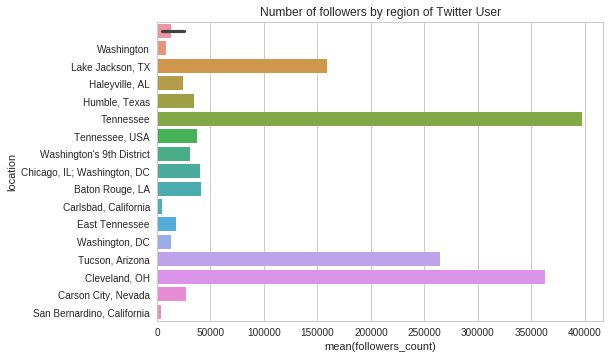

In [19]:
#Barplot by location

##The only user without a location is 'Joe Lieberman' who does not have a geotag attached to his twitter account

sns.set(style="whitegrid")
ax = sns.barplot(x=filtered["followers_count"], y = filtered["location"])
ax.set_title('Number of followers by region of Twitter User')

###Number of followers by Twitter User

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Number of followers by Twitter User')

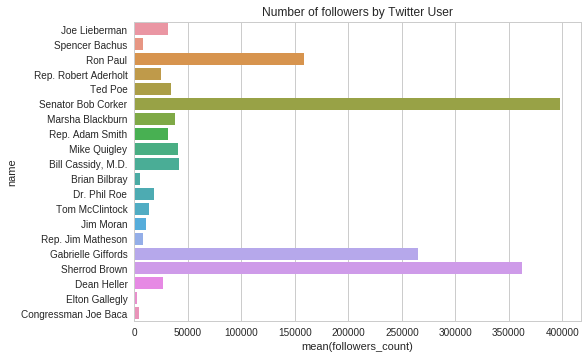

In [20]:
#Barplot of statuses by user
sns.set(style="whitegrid")
ax = sns.barplot(x=filtered["followers_count"], y = filtered["name"])
ax.set_title('Number of followers by Twitter User')

###Number of tweets by Twitter User

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Number of tweets by Twitter User')

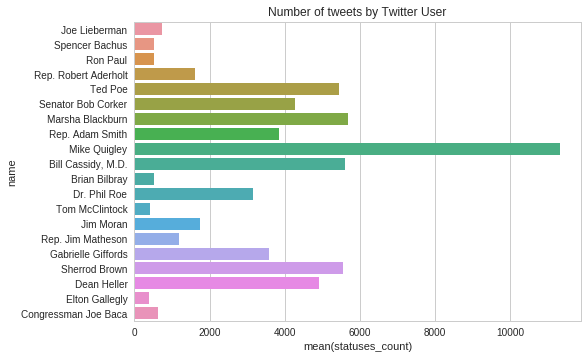

In [21]:
#Barplot by user
sns.set(style="whitegrid")
ax = sns.barplot(x=filtered["statuses_count"], y = filtered["name"])
ax.set_title('Number of tweets by Twitter User')

###Twitter user account creation Timeline 

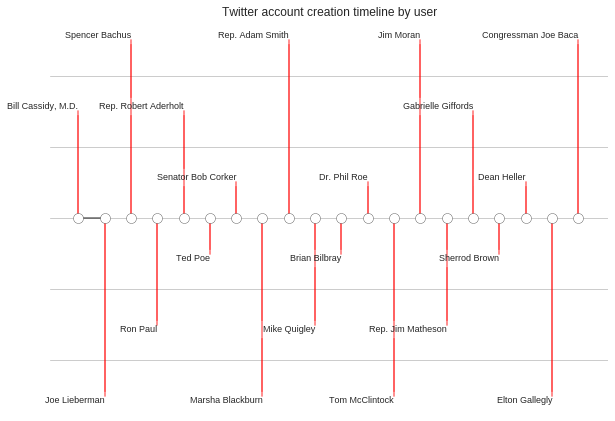

In [22]:
#Timeline code adapted from:
#https://matplotlib.org/gallery/lines_bars_and_markers/timeline.html

#Adjust levels for names
levels = np.array([-5, 5, -3, 3, -1, 1])
#Adjust figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Create the base line
start = min(filtered["created_at"])
stop = max(filtered["created_at"])
ax.plot((start, stop), (0, 0), 'k', alpha=.5)

# Iterate through releases annotating each one
for ii, (iname, idate) in enumerate(zip(filtered["name"], filtered["created_at"])):
    level = levels[ii % 6]
    vert = 'top' if level < 0 else 'bottom'

    ax.scatter(idate, 0, s=100, facecolor='w', edgecolor='k', zorder=9999)
    # Plot a line up to the text
    ax.plot((idate, idate), (0, level), c='r', alpha=.7)
    # Give the text a faint background and align it properly
    ax.text(idate, level, iname,
            horizontalalignment='right', verticalalignment=vert, fontsize=9,
            backgroundcolor=(1., 1., 1., .3))
ax.set(title="Twitter account creation timeline by user")

# Set the xticks formatting
# format xaxis with 3 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=3))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate()

# Remove components for a cleaner look
plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
          list(ax.spines.values())), visible=False)
plt.show()

With respect to the above metadata exploratory analysis, the following are observed:

* The most Tweets appear to have been made from Tennessee followed by Cleaveland, Tucson and Lake Jackson. Additionally, it should be noted that Joe Liberman does not have an associated location to his account.
* Bob corker has the highest number of followers followed by Sherrod Brown and Gabrielle Giffords.
* Mike Quigley has the most tweets followed by Marsha Blackburn, Bill Cassidy and Ted Poe.
* Bill Cassidy was the earliest adopter of Twitter as compared to Joe Baca who was the most recent sign up.

##Wordcloud Plot 

Word clouds can identify trends and patterns that would otherwise be unclear or difficult to see in a tabular format. Frequently used keywords stand out better in a word cloud. Common words that might be overlooked in tabular form are highlighted in larger text making them pop out when displayed in a word cloud.

In [0]:
#Code sourced from : https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

#import the wordcloud package
from wordcloud import WordCloud, STOPWORDS

#Define the word cloud function with a max of 200 words
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(10.0,10.0), 
                   title = None, title_size=20, image_color=False):
    stopwords = set(STOPWORDS)
    #define additional stop words that are not contained in the dictionary
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)
    #Generate the word cloud
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    #set the plot parameters
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout() 

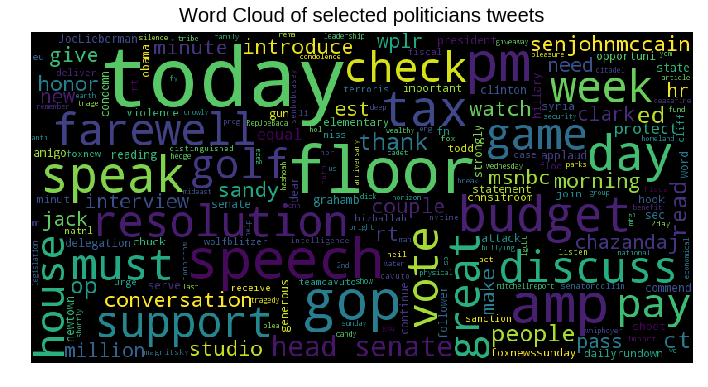

In [24]:
#run the function on the insincere questions
plot_wordcloud(finalized["text"], title="Word Cloud of selected politicians tweets")

##N-gram analysis

An n-gram is a contiguous sequence of n items from a given sample of text or speech. Different definitions of n-grams will allow for the identification of the most prevalent words/sentences in the dataset and helps to understand what composes the tweets of our sample.

It should be noted that prior to displaying individual words or sentences, the text will first be tokenized (based on a desired integer) and then put into a dataframe which will be used to construct bar plots. Tokenization is, generally, an early step in the NLP process, a step which splits longer strings of text into smaller pieces, or tokens. Larger chunks of text can be tokenized into sentences, sentences can be tokenized into words, etc.

In [0]:
#Define the n gram extractor and plot the different 


def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Function to generate a dataframe with n_gram and top max_row frequencies
def generate_ngrams(df, col, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df[col]:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"]
    return temp_df

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Unigram analysis of collected tweets')

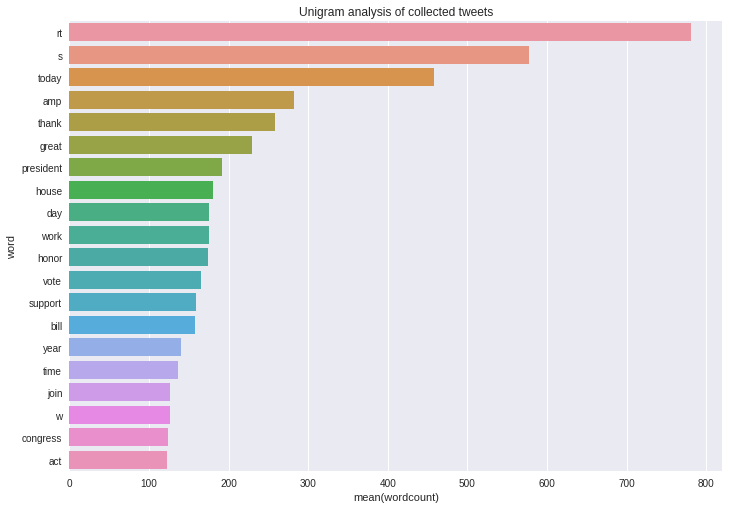

In [26]:
#1 gram word count
onegram = generate_ngrams(df = finalized, col = 'text' ,n_gram = 1, max_row = 20)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="wordcount", y="word", data=onegram)
ax.set_title('Unigram analysis of collected tweets')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Bigram analysis of collected tweets')

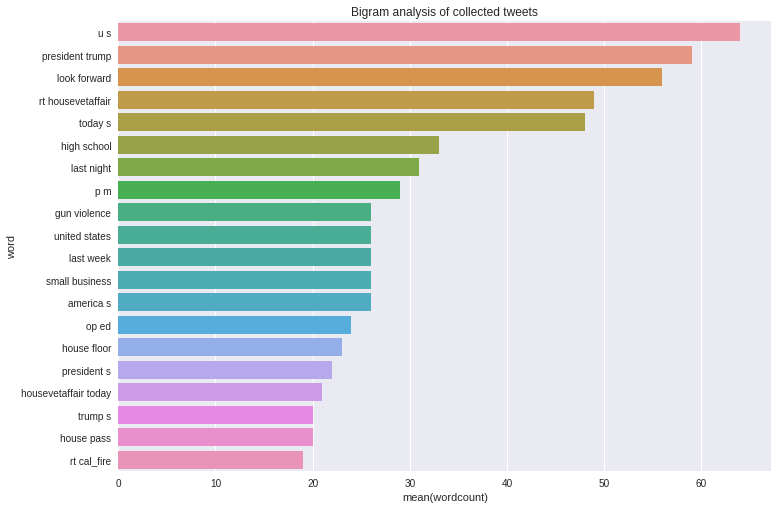

In [27]:
#2 gram word count
twogram = generate_ngrams(df = finalized, col = 'text' ,n_gram = 2, max_row = 20)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax1 = sns.barplot(x="wordcount", y="word", data=twogram)
ax1.set_title('Bigram analysis of collected tweets')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Trigram analysis of collected tweets')

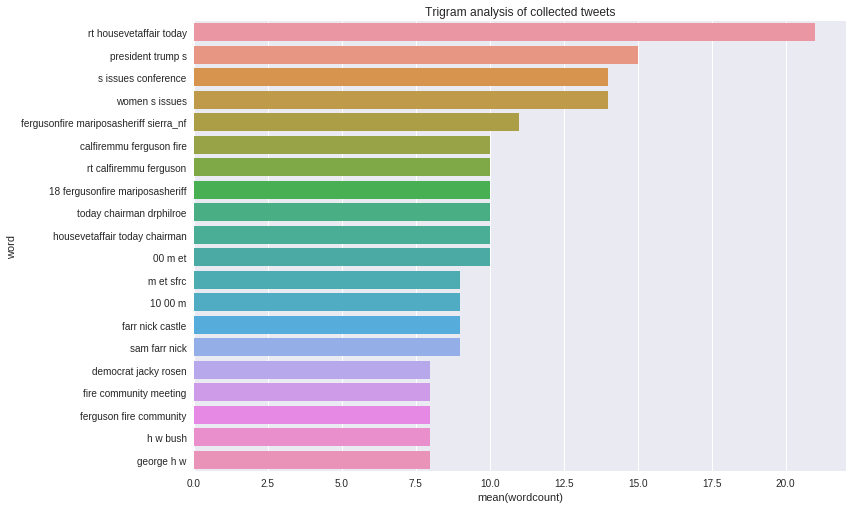

In [28]:
#3 gram word count
threegram = generate_ngrams(df = finalized, col = 'text' ,n_gram = 3, max_row = 20)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax1 = sns.barplot(x="wordcount", y="word", data=threegram)
ax1.set_title('Trigram analysis of collected tweets')

##'Word count ', 'Character Length ', 'Stop words', 'Punctuation' and 'Upper case letter' distribution. 

In order to obtain a better understanding of how the selected users tweet, their number of words, character length used, stop words, punctuation and upper case characters will be investigated using their original tweets.


In [0]:
#import the original tweets and add the classes field
twitter["Classes"] = finalized ["Classes"]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


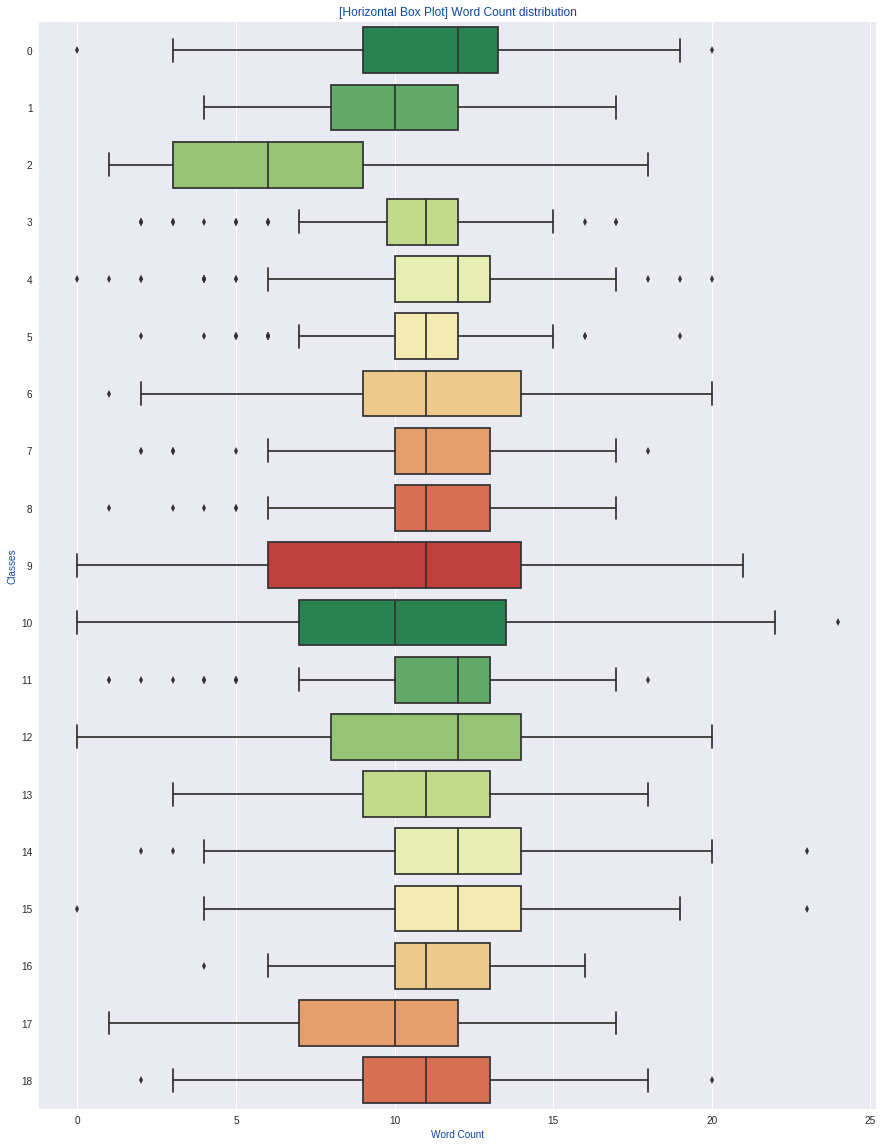

In [30]:
#Word count distribution
twitter["word_count"] = mining["text"].apply(lambda x: len(str(x).split()))
fig, ax = plt.subplots(figsize=(15,20))
sns.boxplot(x="word_count", y="Classes", data=twitter, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Classes', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Word Count distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  "Output arguments") for details.
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


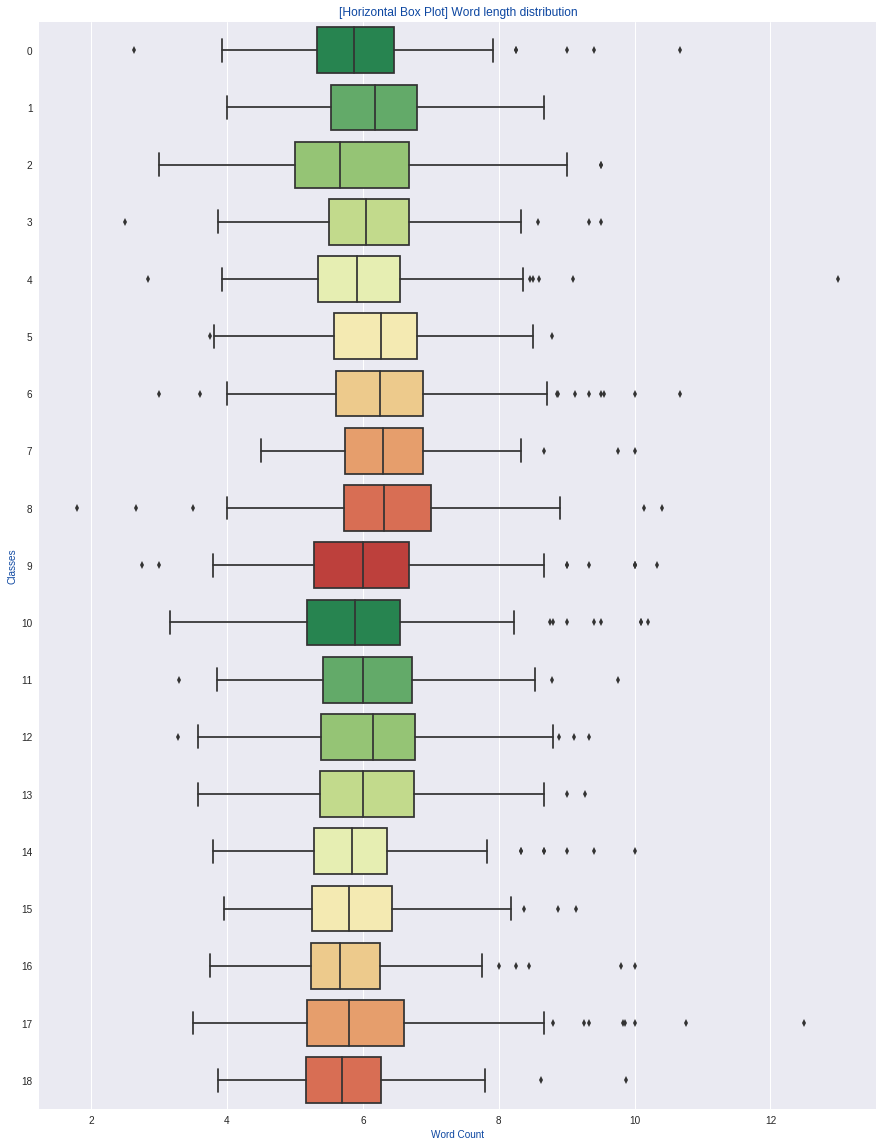

In [31]:
#Word length distribution
twitter["word_length"] = twitter["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
fig, ax = plt.subplots(figsize=(15,20))
sns.boxplot(x="word_length", y="Classes", data=twitter, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Classes', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Word length distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


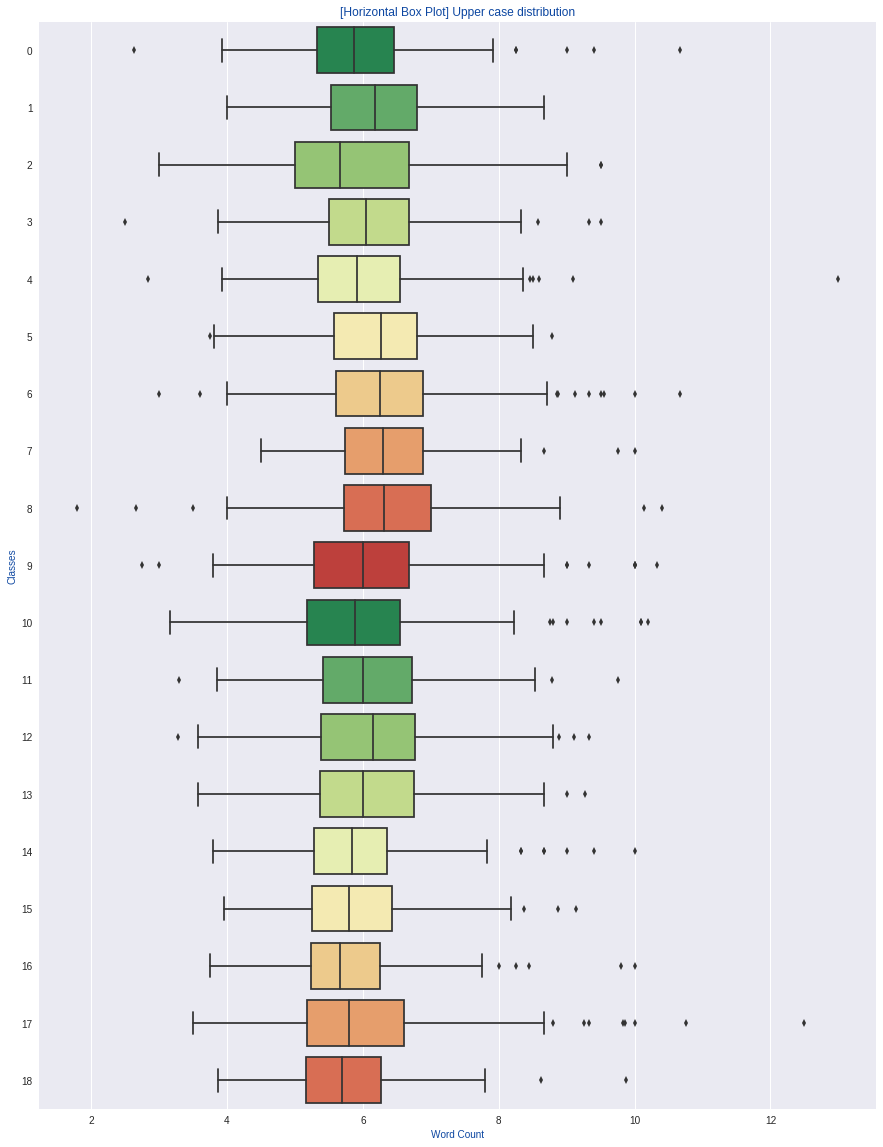

In [32]:
#Upeer case words distribution
twitter["upper_words"] = twitter["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
fig, ax = plt.subplots(figsize=(15,20))
sns.boxplot(x="word_length", y="Classes", data=twitter, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Classes', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Upper case distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


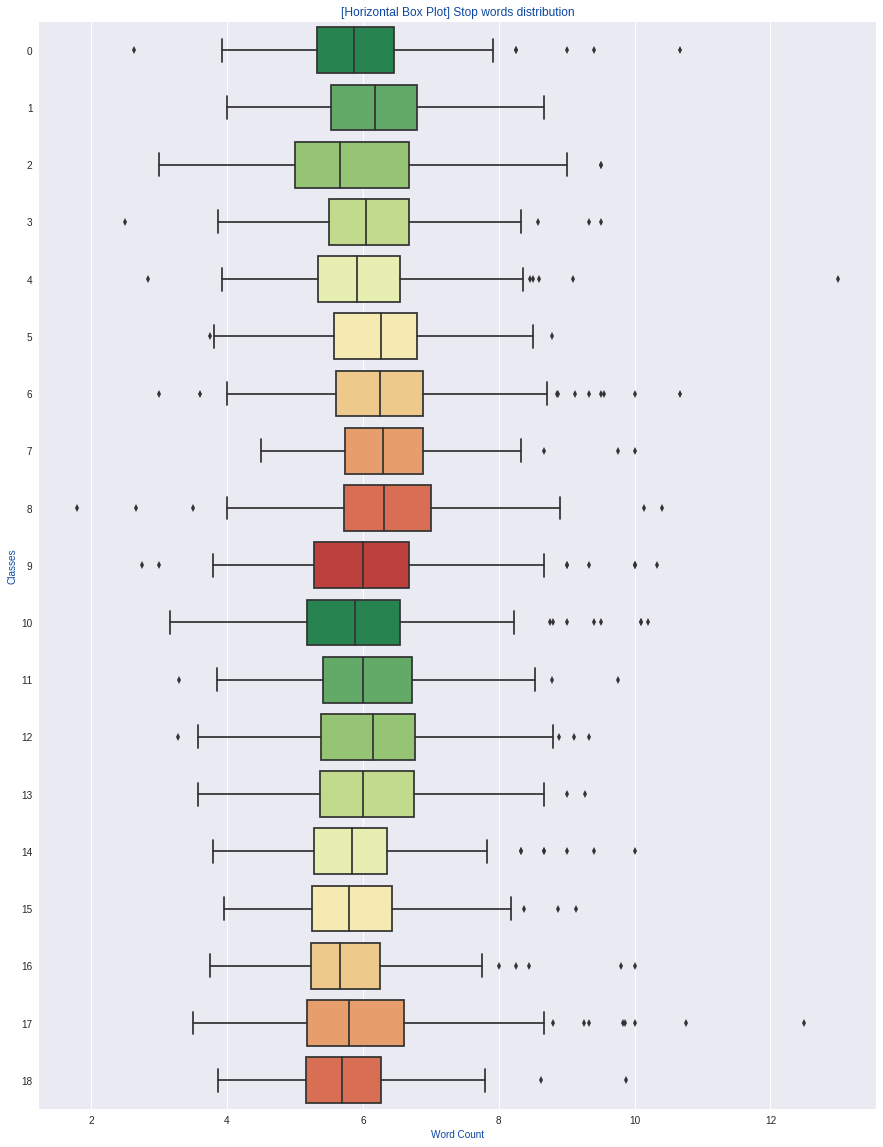

In [33]:
#Stop words distribution
twitter["stop_words_count"] = twitter["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
fig, ax = plt.subplots(figsize=(15,20))
sns.boxplot(x="word_length", y="Classes", data=twitter, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Classes', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Stop words distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


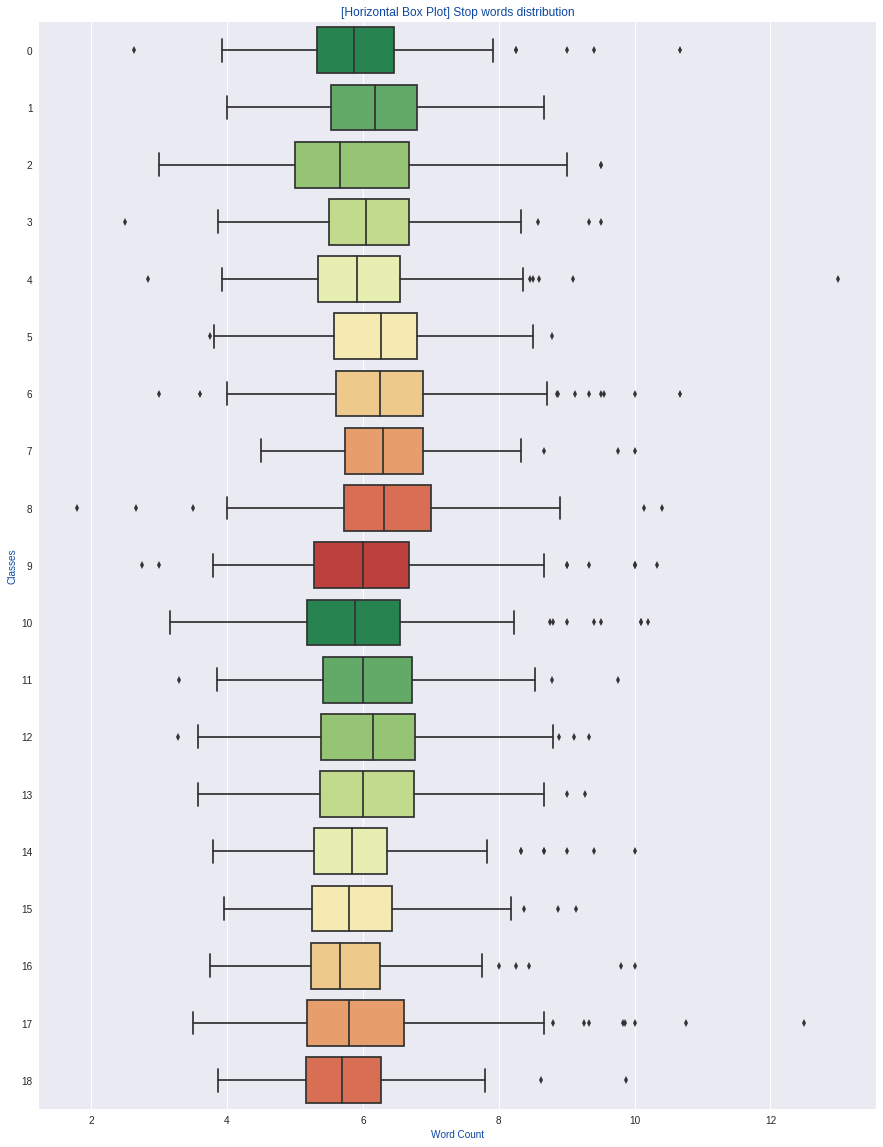

In [34]:
#Punctuations distribution
twitter["punc_count"] = twitter["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
fig, ax = plt.subplots(figsize=(15,20))
sns.boxplot(x="word_length", y="Classes", data=twitter, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Classes', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Stop words distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

With regards to the above sentence construction exploratory analysis, the following can be observed:

* With reference to the 'Word Count' Box plots, Mike Quigley (9) and Bill Cassidy (10) have the tallest box plots as compared to Ted Poe (5) and Ron Paul (3) which have the smallest ones. Additionally, all the box plots appear to have a similar distribution (as indicated by the similar medians) with the exception of Spencer Bachus(2). 
* The 'Word length', 'Upper Case' and 'Stopwords' box plots indicate that all the tweets appear to have a similar distribution.

#Multi-label classification using Machine learning algorithms



To address the objective of assigning tweets to the original user, several machine learning algorithms will be tested. To do so, the cleaned dataset will be filtered to contain only the tweet's identifier ID, its assiciated class (original user) and the text itself. The dataset will first be split into training and testing sets (no holdout set has been considered given the number of observations available for each class) and the bag of words method will be used to encode each text to fit the different considered algorithms.

In [0]:
learning = finalized[["id", "text", "Classes"]].copy()

#Create the dataset for the classification exercise
df = DataFrame.from_records(learning)

In [0]:
#check for the number of observations per class
#check for the number of positive and negative classes
# pd.crosstab(index = df["Classes"], columns = "count" )
#There seems to be around 200 tweets per user

In [0]:
#70-30 split
train, test, y_train, y_test = train_test_split(df["text"], df["Classes"],test_size=0.3, random_state=1000)

In [0]:
#Configure the GloVe word Embedding (could not be used in this context)
#Sourced from: https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

# import io

# embeddings_index = {}
# with io.open('/content/glove.6B.300d.txt', encoding='utf8') as f:
#  for line in tqdm(f):
#     values = line.split(" ")
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

#print('Found %s word vectors.' % len(embeddings_index))
#40,000 word vectors have been found


In [38]:
#Use bag of words approach
#adapted from: https://realpython.com/python-keras-text-classification/

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(train)
X_train = vectorizer.transform(train)
X_test  = vectorizer.transform(test)

#Baseline model (multinomial logistic regression with newton gauss optimization)
classifier = LogisticRegression(solver = 'newton-cg',multi_class  = 'multinomial')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy over test dataset:", score)

Accuracy over test dataset: 0.553116769095698


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


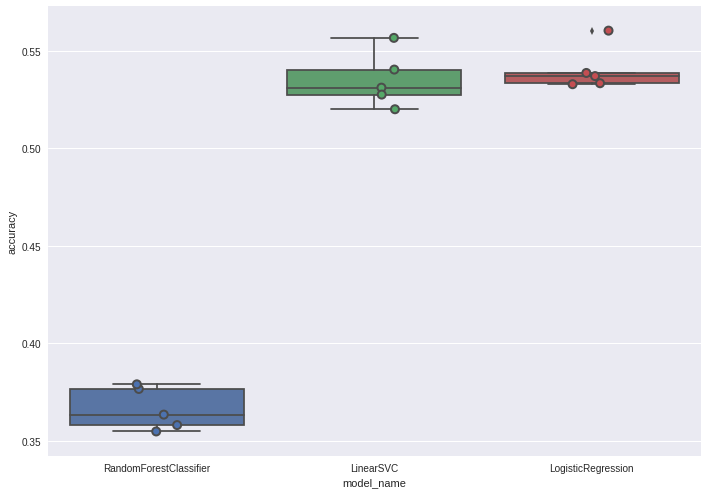

In [39]:
#Below code adapted from:
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

#Model comparison

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0, multi_class  = 'multinomial', solver = 'newton-cg'),
]
#Use 5 fold cross validation on training dataset
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


#plot the models' comparative accuracies
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [40]:
#below code adapted from:
##adapted from: https://realpython.com/python-keras-text-classification/


from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(19, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()
input_dim

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               640600    
_________________________________________________________________
dense_2 (Dense)              (None, 19)                1919      
Total params: 642,519
Trainable params: 642,519
Non-trainable params: 0
_________________________________________________________________


6405

In [41]:
history = model.fit(X_train, y_train,
                     epochs=100,
                     verbose=1,
                     validation_data=(X_test, y_test),
                     batch_size=2655)

#full batch is 2655
#stochastic is 1
#mini batch is between

Instructions for updating:
Use tf.cast instead.
Train on 2655 samples, validate on 1139 samples
Epoch 1/100
2655/2655 [==============================] - 1s 421us/step - loss: 2.9439 - acc: 0.0520 - val_loss: 2.9369 - val_acc: 0.0755
Epoch 2/100
2655/2655 [==============================] - 0s 113us/step - loss: 2.9217 - acc: 0.1126 - val_loss: 2.9284 - val_acc: 0.0931
Epoch 3/100
2655/2655 [==============================] - 0s 110us/step - loss: 2.8964 - acc: 0.2282 - val_loss: 2.9192 - val_acc: 0.1308
Epoch 4/100
2655/2655 [==============================] - 0s 112us/step - loss: 2.8697 - acc: 0.3759 - val_loss: 2.9093 - val_acc: 0.1659
Epoch 5/100
2655/2655 [==============================] - 0s 112us/step - loss: 2.8419 - acc: 0.5296 - val_loss: 2.8987 - val_acc: 0.2072
Epoch 6/100
2655/2655 [==============================] - 0s 111us/step - loss: 2.8131 - acc: 0.6524 - val_loss: 2.8874 - val_acc: 0.2529
Epoch 7/100
2655/2655 [==============================] - 0s 111us/step - loss: 2.7

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [43]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9944
Testing Accuracy:  0.5821


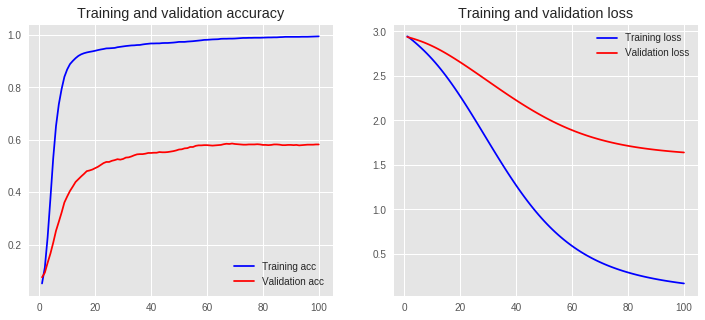

In [44]:
plot_history(history)

Out of the above considered methods, the neural network performs the best (with a testing accuracy of 0.5821) followed by the logistic regression, Support Vector Machine with linear kernel and the Random Forest.

#Similarity

To identify which politicians are similar to each other based on the content of their tweets, the text will be converted to word vectors and the [cosine similarity will then be computed](https://stats.stackexchange.com/questions/304217/how-is-the-similarity-method-in-spacy-computed). 

In [0]:
# my_list = ['JoeLieberman','BachusAL06','RepRonPaul','Robert_Aderholt','JudgeTedPoe','SenBobCorker','VoteMarsha','RepAdamSmith','RepMikeQuigley','BillCassidy','BilbrayCA50','DrPhilRoe','RepMcClintock','Jim_Moran','RepJimMatheson','GabbyGiffords','SenSherrodBrown','DeanHeller','RepJoeBaca']
# for c, value in enumerate(my_list, 0):
#     print(c, value)


In [0]:
#adapted from: https://spacy.io/usage/vectors-similarity

import spacy
nlp = spacy.load('en')

#Politicians list
JoeLieberman = learning.loc[learning["Classes"] == 0]
pol1 = nlp(str(JoeLieberman["text"]))

BachusAL06 = learning.loc[learning["Classes"] == 1]
pol2 = nlp(str(BachusAL06["text"]))

RepRonPaul = learning.loc[learning["Classes"] == 2]
pol3 = nlp(str(RepRonPaul["text"]))

Robert_Aderholt = learning.loc[learning["Classes"] == 3]
pol4 = nlp(str(Robert_Aderholt["text"]))

JudgeTedPoe = learning.loc[learning["Classes"] == 4]
pol5 = nlp(str(JudgeTedPoe["text"]))

SenBobCorker = learning.loc[learning["Classes"] == 5]
pol6 = nlp(str(SenBobCorker["text"]))
           
VoteMarsha = learning.loc[learning["Classes"] == 6]
pol7 = nlp(str(VoteMarsha["text"]))
           
RepAdamSmith = learning.loc[learning["Classes"] == 7]
pol8 = nlp(str(RepAdamSmith["text"]))

RepMikeQuigley = learning.loc[learning["Classes"] == 8]
pol9 = nlp(str(RepMikeQuigley["text"]))           
           
BillCassidy = learning.loc[learning["Classes"] == 9]
pol10 = nlp(str(BillCassidy["text"]))        

BilbrayCA50 = learning.loc[learning["Classes"] == 10]
pol11 = nlp(str(BilbrayCA50["text"]))                    
           
DrPhilRoe = learning.loc[learning["Classes"] == 11]
pol12 = nlp(str(DrPhilRoe["text"]))   

RepMcClintock = learning.loc[learning["Classes"] == 12]
pol13 = nlp(str(RepMcClintock["text"]))            

Jim_Moran = learning.loc[learning["Classes"] == 13]
pol14 = nlp(str(Jim_Moran["text"]))                 

RepJimMatheson = learning.loc[learning["Classes"] == 14]
pol15 = nlp(str(RepJimMatheson["text"]))             
            
GabbyGiffords = learning.loc[learning["Classes"] == 15]
pol16 = nlp(str(GabbyGiffords["text"]))     

SenSherrodBrown = learning.loc[learning["Classes"] == 16]
pol17 = nlp(str(SenSherrodBrown["text"]))
            
DeanHeller = learning.loc[learning["Classes"] == 17]
pol18 = nlp(str(DeanHeller["text"]))                  

RepJoeBaca = learning.loc[learning["Classes"] == 18]
pol19 = nlp(str( RepJoeBaca["text"]))                   

In [0]:
#print(pol1.similarity(pol19)) 
list = ['pol1','pol2','pol3', 'pol4', 'pol5', 'pol6', 'pol7','pol8', 'pol9','pol10',
        'pol11','pol12','pol13','pol14','pol15','pol16','pol17', 'pol18', 'pol19']

scores =[]
 

for x in list:
    for y in list:
     score = (eval(x).similarity(eval(y)))
     results = [x, y, score]
     scores.append(results)

In [47]:
#Create dataframe from similarity scores
similarity = DataFrame.from_records(scores)
#rename the dataframe
similarity.columns = ['politician1', 'politician2', 'Similarity'] 
#replace 1 by 0 for ease of manipulation
similarity = similarity.replace(1, 0)
#group by maximal similarity amount
similar = similarity.groupby(['politician1','politician2'],sort=False).max()
#drop duplicates
similar = similar.sort_values('Similarity', ascending=False)
similar = similarity.drop_duplicates(['Similarity'], keep='last')
#sort by maximum by finding common field
similar[similar['Similarity'].isin(similar.groupby('politician1').max()['Similarity'].values)]

,politician1,politician2,Similarity
19,pol2,pol1,0.951587
39,pol3,pol2,0.984964
57,pol4,pol1,0.956556
76,pol5,pol1,0.981886
95,pol6,pol1,0.994671
116,pol7,pol3,0.975735
138,pol8,pol6,0.996026
155,pol9,pol4,0.972631
175,pol10,pol5,0.990946
199,pol11,pol10,0.993277


From the above similarity matrix, the most similar politicians based on the content of their tweets are:

| Index | Politician 1     | Politician 2     | Similarity |
|-------|------------------|------------------|------------|
| 138   | Adam Smith       | Bob Corker       | 0.996126   |
| 95    | Bob Corker       | Joe Liberman     | 0.994671   |
| 258   | Jim Moran        | Phil Roe         | 0.99456    |
| 199   | Brian Bilbray    | Bill Cassidy     | 0.993277   |
| 307   | Sherrod Brown    | Robert Aderholt  | 0.993118   |
| 344   | Joe Baca         | Ron Paul         | 0.992034   |
| 175   | Bill Cassidy     | Ted Poe          | 0.990946   |
| 329   | Dean Heller      | Marsha Blackburn | 0.988344   |
| 297   | Gabby Giffords   | Tom McClintock   | 0.98759    |
| 39    | Ron Paul         | Spencer Bachus   | 0.984964   |
| 274   | Jim Matheson     | Mike Quigley     | 0.982322   |
| 76    | Ted Poe          | Joe Liberman     | 0.981886   |
| 116   | Marsha Blackburn | Ron Paul         | 0.976566   |
| 155   | Mike Quigley     | Robert Aderholt  | 0.972952   |
| 235   | Tom McClintock   | Adam Smith       | 0.971056   |
| 219   | Phil Roe         | Brian Bilbray    | 0.96982    |
| 57    | Robert Aderholt  | Joe Liberman     | 0.956287   |
| 19    | Spencer Bachus   | Joe Liberman     | 0.951587   |


#Conclusion


To summarize and address the original objectives:

* The Neural Network implementation manages to classify a user's tweets with an overall accuracy of 0.582.
* The most similar politicians are  Adam Smith and Bob Corker (based on the cosine similarity - 0.996).

#Limitations and Future Work

This project faced two main limitations in the timeframe (2 days) that it was alloted which related to:

* The use of the Word Embedding model (GloVe) in the google Collab platform
* The permissions with regards to mining several consecutive tweets through the Twitter API

Therefore, to address the above and improve this project, the following steps could be undertaken:

* Use another package/view developper options with regards to the Twitter API for easier streaming
* Investigate how to implement word embedding models in Google Collab
* Investigate how to apply dimensionality reduction techniques (T-SNE, PCA ... ) to the mined dataset efficiently
* Investigate the application of unsupervised methods to this project
* Investigate how to apply topic models to this context (LDA, PSLA ...)
* Determine how to conduct parameter tuning for the selected models
* Determine how to apply sequence based deep learning methods (LSTM)